In [22]:
import snap
import numpy as np
import matplotlib.pyplot as plt

import random

## Q2 Rolx and ReFex

In this problem, we will explore the structural role extraction algorithm Rolx and its recursive
feature extraction method ReFex. As part of this exploration, we will work with a dataset representing
a scientist co-authorship network, which can be dowloaded at http://www-personal.umich.edu/~mejn/netdata/netscience.zip. Although the graph is weighted, for simplicity we treat it as undirected and unweighted in this problem.

## Q2.1 Basic Features

In [23]:
Fin = snap.TFIn("hw1-q2.graph")
Graph = snap.TUNGraph.Load(Fin)
print("The graph has", Graph.GetNodes(), "nodes and", Graph.GetEdges(), "edges.")

The graph has 1589 nodes and 2742 edges.


In [30]:
def CalculateLocalVector(Graph):
    # dim-1 : the degree of v,
    # dim-2 : the number of edges in the egonet of v
    # dim-3 : the number of edges that connect the egonet of v and the rest of the graph, 
    #           i.e., the number of edges that enter or leave the egonet of v.
    
    N = Graph.GetNodes()
    V_local = np.zeros((N,3))
    
    idx = 0
    for NI in Graph.Nodes():
        V_local[idx, 0] = NI.GetDeg()
        #print(idx, NI.GetId()) # they are equal
        
        V_ids = snap.TIntV()
        V_ids.Add(NI.GetId())
        degree_sum = NI.GetDeg()
        for Id in NI.GetOutEdges():
            V_ids.Add(Id)
            degree_sum += Graph.GetNI(Id).GetDeg()
            #print("edge (%d %d)" % (NI.GetId(), Id))
        G_ego = snap.ConvertSubGraph(snap.PUNGraph, Graph, V_ids)
        
        V_local[idx, 1] = G_ego.GetEdges()
        V_local[idx, 2] = degree_sum - 2 * G_ego.GetEdges()
        
        idx += 1
    return V_local

Calculate the local feature of the graph

In [31]:
V_local = CalculateLocalVector(Graph)

In [63]:
def Sim_Graph_local_feature(Graph, V_local, idx):
    #V_local = CalculateLocalVector(Graph)
    ref = V_local[idx,:]
    norm_v_local = np.linalg.norm(V_local, axis=1)
    flag = norm_v_local > 0
    M_sim = np.zeros(V_local.shape[0])
    if np.linalg.norm(ref) == 0:
        return M_sim
    M_sim[flag] = np.dot(V_local, np.transpose(ref))[flag] / norm_v_local[flag]
    M_sim = M_sim / np.linalg.norm(ref)
    return M_sim

In [64]:
V_sim = Sim_Graph_local_feature(Graph,V_local, 9)
ranked_sim = np.argsort(V_sim)
for i in range(10):
    print("Top", (i+1), " similar node ID is :", ranked_sim[-(2+i)], "with score", V_sim[ranked_sim[-(2+i)]])

Top 1  similar node ID is : 415 with score 0.999615754068427
Top 2  similar node ID is : 288 with score 0.9963436806278279
Top 3  similar node ID is : 286 with score 0.9963436806278279
Top 4  similar node ID is : 1054 with score 0.9961182380000688
Top 5  similar node ID is : 1336 with score 0.9961182380000688
Top 6  similar node ID is : 189 with score 0.9957906172043477
Top 7  similar node ID is : 275 with score 0.9957906172043477
Top 8  similar node ID is : 104 with score 0.9952159568022303
Top 9  similar node ID is : 785 with score 0.9952159568022303
Top 10  similar node ID is : 103 with score 0.9952159568022303


## Q2.2 Recursive Features

In [58]:
def Concate_Recursive_Feature(Graph, V_local):    
    N = V_local.shape[0]
    k = V_local.shape[1]
    V_recur = np.zeros((N,2*k))
    
    idx = 0
    for NI in Graph.Nodes():
        vec_sum = np.zeros((1,k))
        n_neighbor = 0
        for Id in NI.GetOutEdges():
            vec_sum = vec_sum + V_local[Id, :]
            n_neighbor += 1
        
        if(n_neighbor > 0):
            V_recur[idx, 0:k] = vec_sum/n_neighbor
            V_recur[idx, k:2*k] = vec_sum
        
        idx += 1
    return np.concatenate((V_local, V_recur), axis = 1)

In [62]:
V_local = CalculateLocalVector(Graph)
V_Recur = Concate_Recursive_Feature(Graph, V_local)
V_Recur = Concate_Recursive_Feature(Graph, V_Recur)
print("Recursive Features after two iterations has shape :", V_Recur.shape)

Recursive Features after two iterations has shape : (1589, 27)


In [65]:
V_sim = Sim_Graph_local_feature(Graph,V_Recur, 9)
ranked_sim = np.argsort(V_sim)
for i in range(10):
    print("Top", (i+1), " similar node ID is :", ranked_sim[-(2+i)], "with score", V_sim[ranked_sim[-(2+i)]])

Top 1  similar node ID is : 973 with score 0.9959848829010806
Top 2  similar node ID is : 537 with score 0.9946130044020561
Top 3  similar node ID is : 415 with score 0.9937284425239259
Top 4  similar node ID is : 496 with score 0.9922839741918225
Top 5  similar node ID is : 25 with score 0.9922413199302673
Top 6  similar node ID is : 24 with score 0.9922413199302673
Top 7  similar node ID is : 82 with score 0.9904971299996077
Top 8  similar node ID is : 320 with score 0.9902105236648335
Top 9  similar node ID is : 296 with score 0.9888074594500342
Top 10  similar node ID is : 275 with score 0.9873055774103079


## Q2.3 Role Discovery

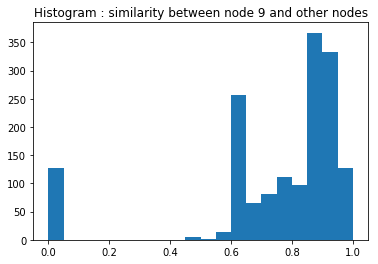

In [141]:
hist, bin_edges , _ = plt.hist(V_sim,bins=20)
title = plt.title("Histogram : similarity between node 9 and other nodes")

In [76]:
# import networkx for drawing the graph
import networkx as nx

Draw the subgraph of the similar nodes

In [157]:
def Draw_SubGraph(Graph, NI_id):
    Nodes = []
    Edges = []
    NI = Graph.GetNI(NI_id)
    Nodes.append(NI_id)
    dict_color = {NI_id : 'r'}
    for Id in NI.GetOutEdges():
        dict_color[Id] = 'b'
        Nodes.append(Id)
        Edges.append((NI_id, Id))
        NI_neighbor = Graph.GetNI(Id)
        for Id_ner in NI_neighbor.GetOutEdges():
            dict_color[Id_ner] = 'b'
            Nodes.append(Id_ner)
            Edges.append((Id, Id_ner)) 
            NI_neighbor_ner = Graph.GetNI(Id)
            for Id_ner_ner in NI_neighbor_ner.GetOutEdges():
                dict_color[Id_ner_ner] = 'b'
                Nodes.append(Id_ner_ner)
                Edges.append((Id_ner, Id_ner_ner)) 
    dict_color[NI_id] = 'r'
    g=nx.Graph()
    g.add_nodes_from(Nodes)
    g.add_edges_from(Edges)
    nx.draw_networkx(g, node_color=dict_color.values())
    #plt.show()

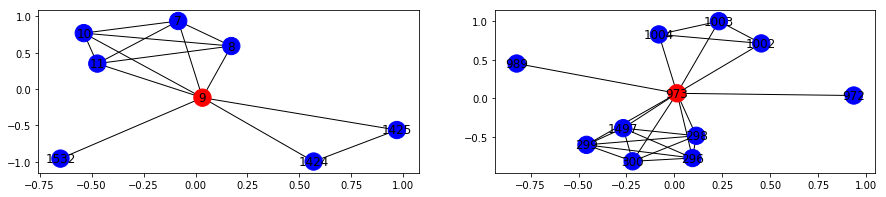

In [159]:
plt.figure(figsize=(15,3))
plt.subplot(121)
Draw_SubGraph(Graph,9)
plt.subplot(122)
Draw_SubGraph(Graph,973)

In [161]:
ranked_sim[-(2+i)]

973

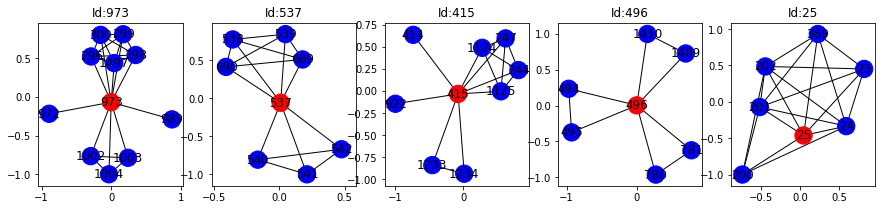

In [162]:
V_sim = Sim_Graph_local_feature(Graph,V_Recur, 9)
ranked_sim = np.argsort(V_sim)
plt.figure(figsize=(15,3))
plt.subplot(11)
Draw_SubGraph(Graph,9)
for i in range(5):
    plt.subplot(1,6,(i+2))
    Draw_SubGraph(Graph, int(ranked_sim[-(2+i)]))
    plt.title("Id:"+str(ranked_sim[-(2+i)]))
    #print("Top", (i+1), " similar node ID is :", ranked_sim[-(2+i)], "with score", V_sim[ranked_sim[-(2+i)]])